In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 20 # Top 10% highest l2-magnitude filters

In [4]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

l_num = 1
F = 0


print(f" ============ LAYER {l_num} ==================")
top10F=topKfilters(model, l_num, k=k)
filters = get_filter(model, l_num)[:,:,:, top10F]
print(filters.shape)

s, a = getSymAntiSymTF(filters)
theta = getSobelTF(filters)
a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
#beta = a_energy/total_energy
beta.append(tf.reduce_mean(a_energy/total_energy, (0)))

e_beta.append(np.mean(tf.reduce_mean(a_energy/total_energy, (0))))
'''min_beta.append(e_beta[-1] - np.min(beta))
max_beta.append(np.max(beta)-e_beta[-1])'''
#tf.reduce_mean(a_energy/total_energy, (0))
top10F

 ============ LAYER 1 ==================
(3, 3, 64, 12)


[18, 59, 19, 0, 29, 10, 30, 47, 52, 55, 13, 20]

(3, 3, 12, 64)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.


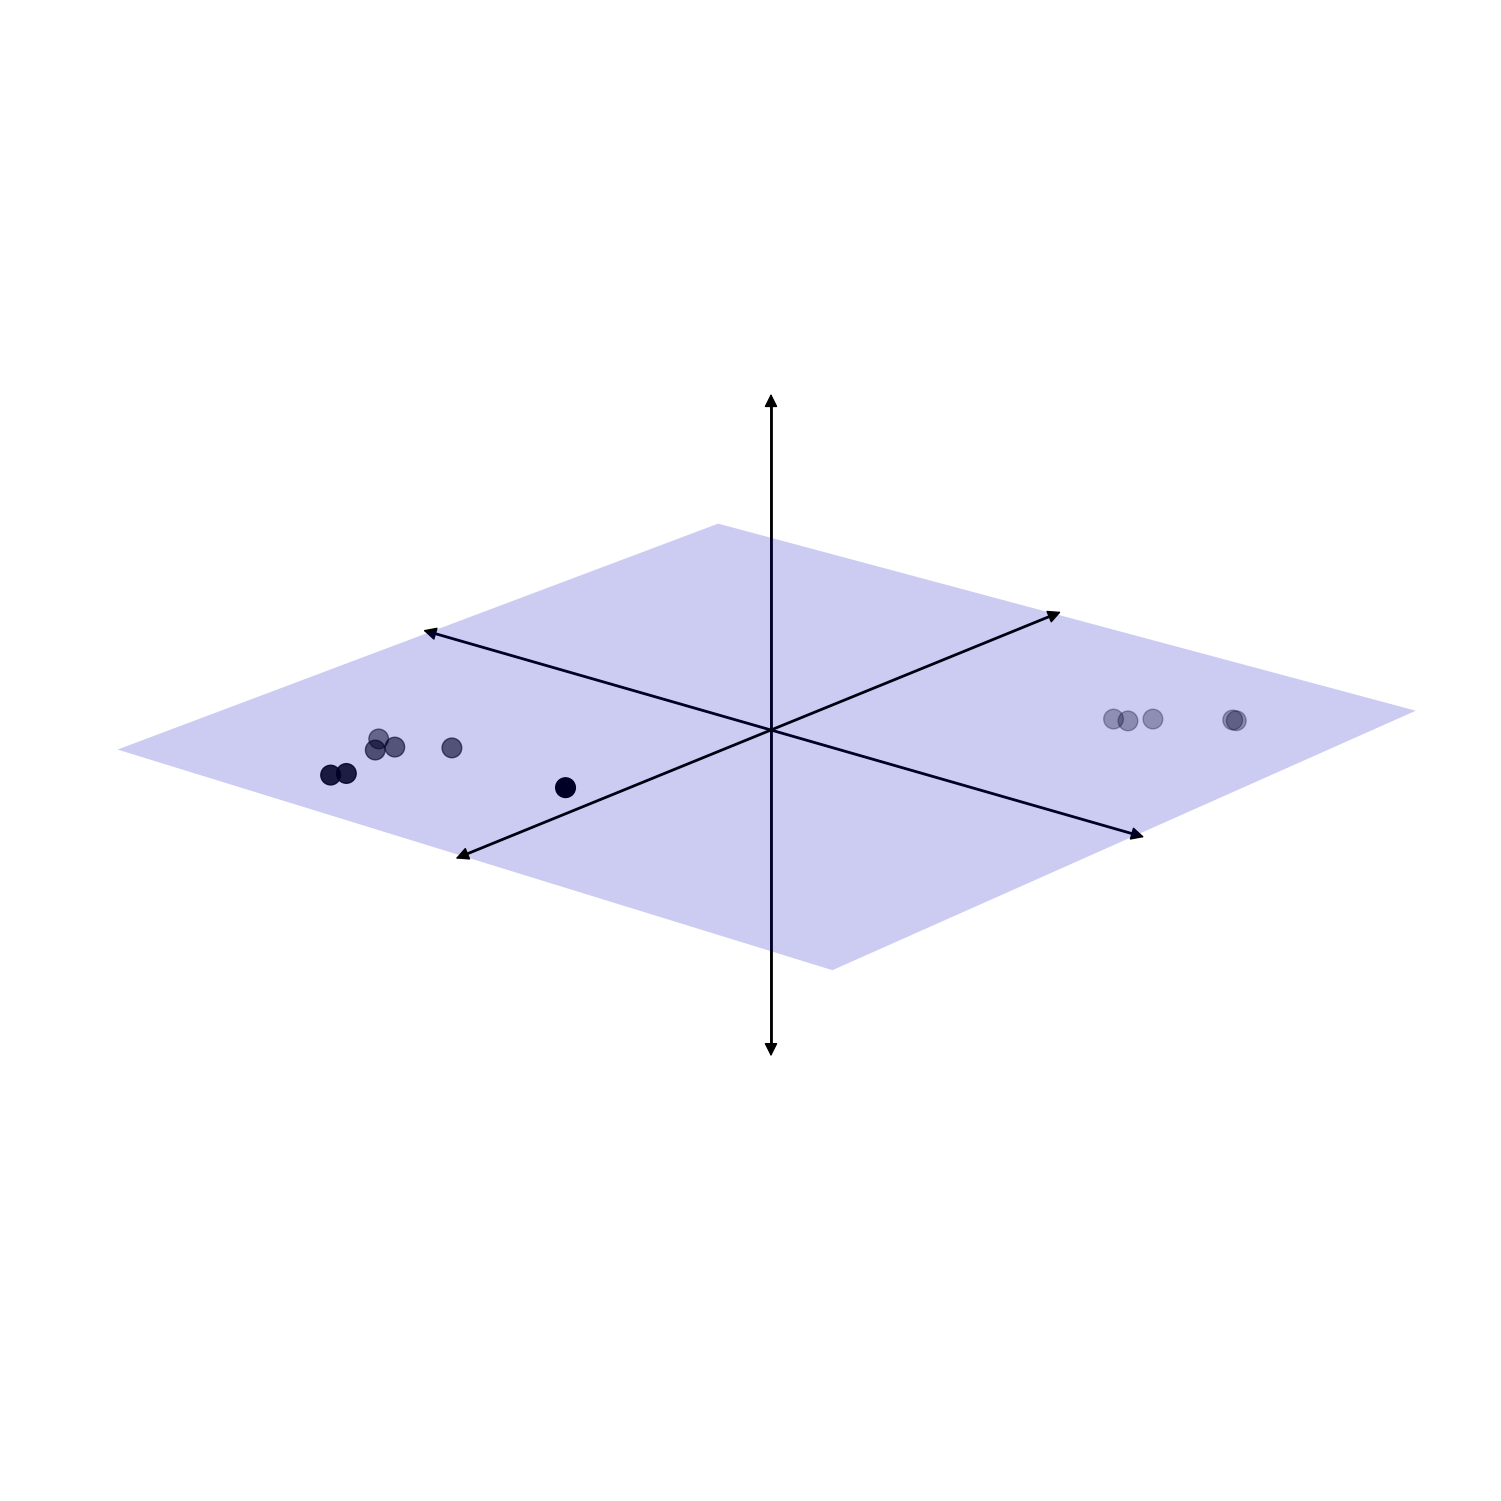

CompletedProcess(args=['pdfcrop ', 'vgg16_L1_f0_pure.pdf'], returncode=1)

In [5]:


channels = topKchannels(model,l_num,F, k=20)
filters = get_filter(model,l_num)[:,:,channels, :]

theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
filters = a
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# Create a new figure and a 3D axis
fig = plt.figure(figsize=(15, 15),constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Remove the panes (walls)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove the pane lines
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Remove grid lines
ax.grid(False)

# Remove default tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Create the axes lines
axis_length = 10
ax.plot([-1, 1], [0, 0], [0, 0], 'k-', linewidth=2)  # x-axis
ax.plot([0, 0], [-1, 1], [0, 0], 'k-', linewidth=2)  # y-axis
ax.plot([0, 0], [0, 0], [-1, 1], 'k-', linewidth=2)  # z-axis

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='<|-|>', shrinkA=0, shrinkB=0)


    
a = Arrow3D([- 1.02, 1.02], [0, 0], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D( [0, 0],[- 1.02, 1.02], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0],[-1.02, 1.02], **arrow_prop_dict, color='k')
ax.add_artist(a)


# Color the x,y plane
xx, yy = np.meshgrid(range(-1, 2), range(-1, 2))
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2, color='blue') 
# Add text to the x,y plane
#ax.text(0, 0, 0, "X-Y Plane", fontsize=14, ha='center', va='center', 
#        zdir='x', zorder=20)# Example: Plot some 3D points
points = np.array([x,y,z]).T*3
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='k', s=200)
plt.axis('off')
# Show the plot

ax.view_init(elev=20, azim=40)

fig.savefig(f'vgg16_L{l_num}_f{F}_pure.pdf', dpi=600,  transparent=True, bbox_inches='tight')
plt.show()

import subprocess
subprocess.run(["pdfcrop ", f'vgg16_L{l_num}_f{F}_pure.pdf']) 


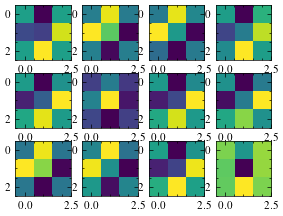

In [20]:
fig, axs = plt.subplots(3,4)
for i,ax in enumerate(axs.ravel()):
    ax.imshow(dct2(np.float16(filters[:,:,i,F])))

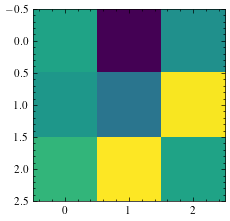

In [21]:
from scipy import ndimage, fft

plt.imshow(dct2(np.float16(tf.reduce_sum(filters[:,:,:,F], axis=-1))))

In [7]:
#var = 2/(128*9)

img =  cv2.imread('input4.png', 0)/255. 
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(224, 224)


In [8]:
np.var(img), 1/(128*9)


(0.023040123255935026, 0.0008680555555555555)

In [9]:
x.shape

(12,)

(3, 3, 12, 1)
0


KeyboardInterrupt: 

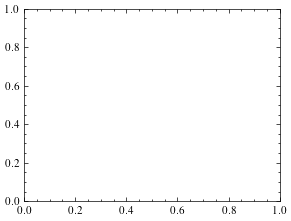

In [10]:
w,b = model.get_layer(conv_layers[l_num].name).get_weights()
w = tf.cast(tf.expand_dims(filters[:,:,:,F], -1), dtype=tf.float32)
print(w.shape)

x = img


directory = f"figures/antisym_{l_num}_{F}_pure"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(200):
	print(i)
	fig, ax = plt.subplots()
	x = x/np.std(x)
	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )
	
	x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)

	im = ax.imshow(x[0,:,:,0])
	ax.plot(112, 112, marker = '+', color='red')
	ax.set(xlim=(0, 224), ylim=(0, 224))

	fig.colorbar(im, orientation='vertical')
	fig.savefig(directory + f'/vgg16_{l_num}_f{F}_{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')


